In [114]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import json
import cv2
import torch

datapath = r"C:\Users\Nikolaj\OneDrive - Danmarks Tekniske Universitet\DTU\Kandidat\MasterThesis\Code\MasterThesis\Data"
# os.listdir(datapath)

img_paths = glob.glob(datapath+'\*\*.jpg')
calib_paths = glob.glob(datapath+'\*\*.txt')

In [115]:
print(img_paths[0])
print(calib_paths[0])
torch.from_numpy(cv2.imread(img_paths[0]))
torch.tensor(json.load(open(calib_paths[0],'r',encoding='latin'))['GoalCalibrationPoints'])

C:\Users\Nikolaj\OneDrive - Danmarks Tekniske Universitet\DTU\Kandidat\MasterThesis\Code\MasterThesis\Data\0068beb9-551c-4db1-96be-1f7ba29d13bd\0068beb9-551c-4db1-96be-1f7ba29d13bd.jpg
C:\Users\Nikolaj\OneDrive - Danmarks Tekniske Universitet\DTU\Kandidat\MasterThesis\Code\MasterThesis\Data\0068beb9-551c-4db1-96be-1f7ba29d13bd\0068beb9-551c-4db1-96be-1f7ba29d13bd.txt


tensor([[2361.8108, 1697.9369],
        [2644.2529, 1822.7369],
        [2356.8843, 2169.2212],
        [2649.1792, 2138.0212]])

In [116]:
calib1 = json.load(open(calib_paths[0],'r',encoding='latin'))
calib1['GoalCalibrationPoints']

[[2361.810791015625, 1697.9368896484375],
 [2644.2529296875, 1822.7369384765625],
 [2356.88427734375, 2169.22119140625],
 [2649.17919921875, 2138.021240234375]]

In [117]:
import glob
import cv2
import torch
from torch.utils.data import Dataset
import json

class GoalCalibrationDataset(Dataset):
    def __init__(self,datapath):
        self.img_list = glob.glob(datapath + '/*/*.jpg')
        self.calibration_list = glob.glob(datapath + '/*/*.txt')
    def  __len__(self):
        return len(self.calibration_list)
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        calibration_path = self.calibration_list[idx]
        img = cv2.imread(img_path)
        b, g, r = cv2.split(img)
        img = cv2.merge([r,g,b])
        calibration_json = json.load(open(calibration_path,'r',encoding='latin'))
        calibrationpts = calibration_json['GoalCalibrationPoints']
        # convert image to tensor
        img_tensor = torch.from_numpy(img)
        # change channel order from Width,Height,Channels to Channels,Width,Height
        img_tensor = img_tensor.permute(2, 0, 1)
        calibrationpts_tensor = torch.tensor(calibrationpts)
        return img_tensor,calibrationpts_tensor

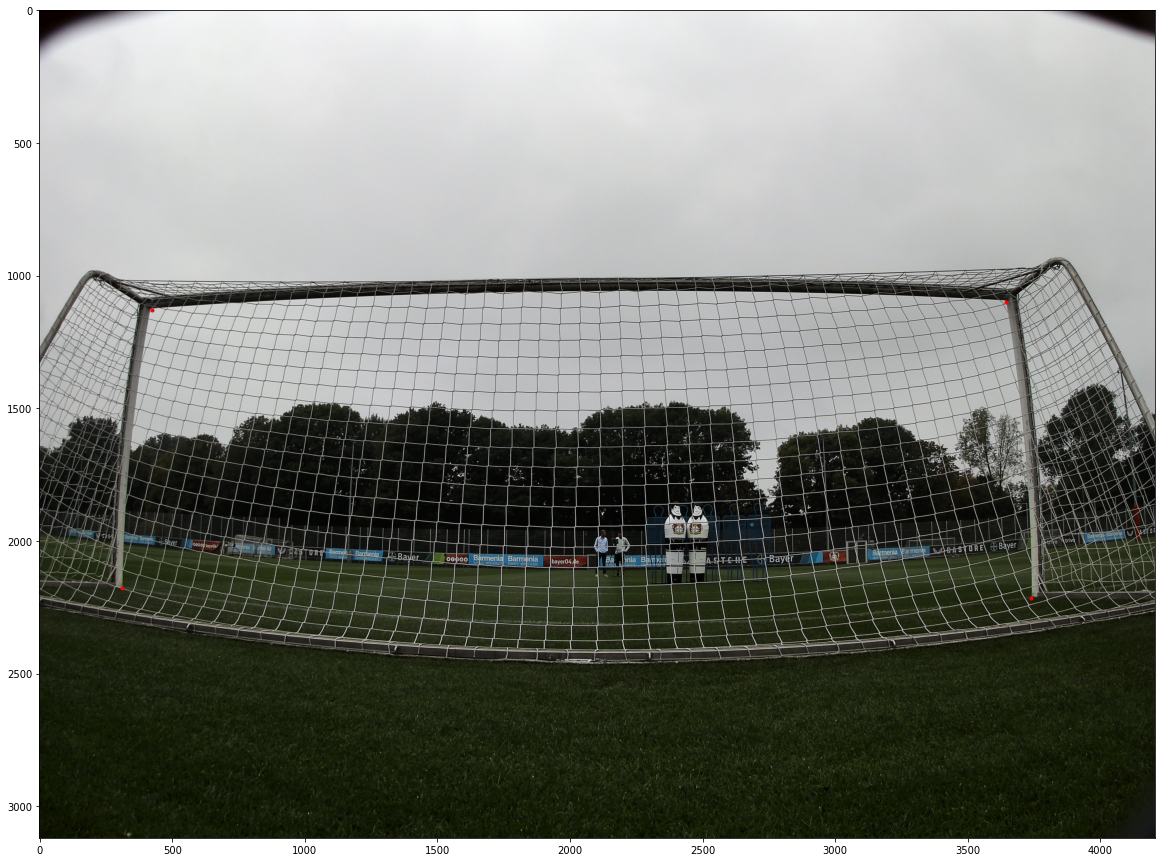

In [175]:
datasetclass = GoalCalibrationDataset(datapath)
img0,cal0 = datasetclass.__getitem__(10)

_,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(img0.permute(1,2,0))
ax.plot(*cal0.T,'r.')

In [176]:
def gaussian1DKernel(sigma):
    h = np.maximum(np.ceil(5*sigma), 1)
    var = sigma**2
    x = np.arange(-h,h+1)
    g = 1/(np.sqrt(2*np.pi*var))*np.exp(-x**2/(2*var))
    gx = -x/var * g
    return g[:,None],gx[:,None]

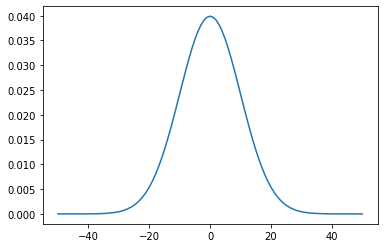

In [177]:
gtemp,gxtemp = gaussian1DKernel(10)
htemp = np.maximum(np.ceil(5*10), 1)
xtemp = np.arange(-htemp,htemp+1)
plt.plot(xtemp,gtemp)

In [194]:
def gaussian(img, pt, sigma):
    # Draw a 2D gaussian
    img = img/255
    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        print('failed')
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    print(f'g: {g.shape}\n{g}')
    print(f'max of g: {np.max(g)}')
    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])
    
    print(f'g_x: {g_x}')
    print(f'g_y: {g_y}')
    print(f'center vals of g: {(g[g_y[0]:g_y[1], g_x[0]:g_x[1]]).shape}\n{g[g_y[0]:g_y[1], g_x[0]:g_x[1]]}')
    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

In [179]:
img0.permute(1,2,0).shape

torch.Size([3120, 4208, 3])

In [180]:
cal0

tensor([[ 422.4843, 1129.7684],
        [3642.6531, 1098.5685],
        [ 312.4633, 2179.0737],
        [3739.5374, 2213.5579]])

In [181]:
img0.permute(1,2,0)[394:425,986:1017].shape

torch.Size([31, 31, 3])

In [182]:
img0gray = cv2.cvtColor(img0.permute(1,2,0).detach().cpu().numpy(),cv2.COLOR_BGR2GRAY)

In [198]:
heatmap = torch.from_numpy(gaussian(img0gray, cal0[0], 10))
heatmap.shape

g: (61, 61)
[[0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 ...
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]]
max of g: 1.0
g_x: (0, 61)
g_y: (0, 61)
center vals of g: (61, 61)
[[0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 ...
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]]


torch.Size([3120, 4208])

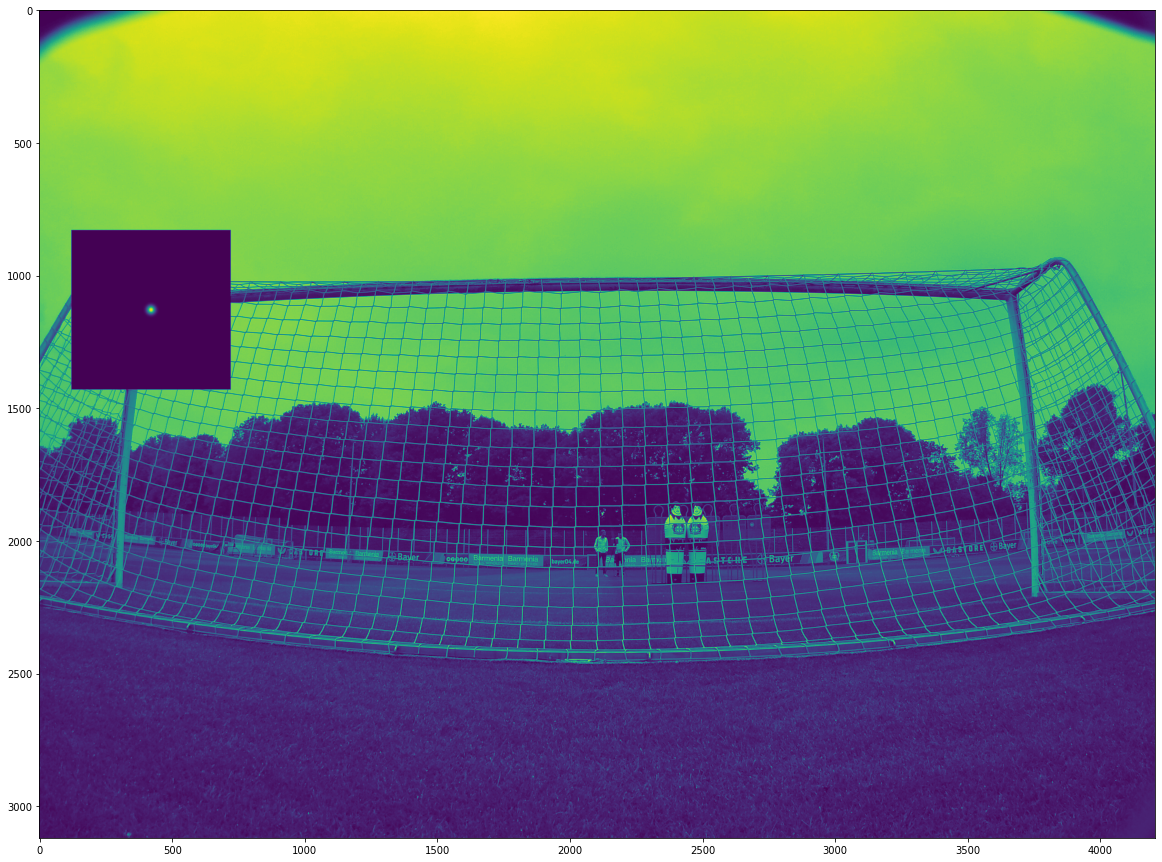

In [199]:
_,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(heatmap)

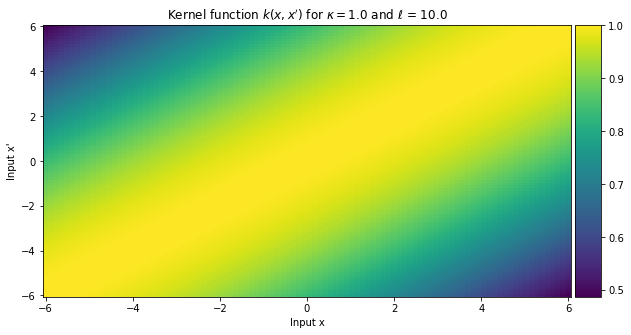

In [168]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


squared_exponential = lambda tau_squared, kappa, scale: kappa**2*np.exp(-0.5*tau_squared/scale**2)

def se_kernel(X1, X2, theta, jitter=1e-8):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1     -- NxD matrix
    X2     -- MxD matrix
    theta  -- vector with 2 elements: [kappa, scale]
    jitter -- scalar
    
    returns NxM matrix    
    """
    # extract hyperparameters
    kappa, scale = theta[0], theta[1]

    # compute all the pairwise squared distances efficiently
    dists_squared = np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1)
    
    # squared exponential covariance function
    K = squared_exponential(dists_squared, kappa, scale)
    
    # add jitter to diagonal for numerical stability
    if len(X1) == len(X2) and np.allclose(X1, X2):
        K = K + jitter*np.identity(len(X1))
    
    return K

# create an Nx1 vector of equidistant points in [-6, 6]
N = 100
Xp = np.linspace(-6, 6, N)[:, None]

# hyperparameters
kappa = 1.
scale = 10.

num_samples = 10

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
Kpp = se_kernel(Xp, Xp, theta=[kappa, scale])
im = ax.pcolormesh(Xp.flatten(), Xp.flatten(), Kpp, shading='auto')
ax.set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ for $\kappa = {kappa:2.1f}$ and $\ell$ = {scale:2.1f}")
ax.grid(False)
add_colorbar(im, fig, ax)